## Compiling United States Department of Agriculture (USDA) Crop Data

In [1]:
import os, sys, json
from fnmatch import fnmatch
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly
import plotly.graph_objects as go
import plotly.express as px
import pycountry

### United States Department of Agriculture (USDA)
- [UDSA Foreign Agricultural Service (FAS)](https://www.fas.usda.gov/)
- [UDA-FAS International Production Assessment Division](https://ipad.fas.usda.gov/Default.aspx)
  


### FAO AgroMaps

In [13]:
# Reference tables ----------------------------------- #
dict_element = {
    '031':'Harvested Area',
    '041':'Yield',
    '051':'Production',
    '061':'Planted Area',
    '31':'Harvested Area',
    '41':'Yield',
    '51':'Production',
    '61':'Planted Area',
}
df = pd.read_excel('./data/fao_agromaps/ZAF/Lookup_table.xls',skiprows=1)
dict_code = df.set_index('Code').to_dict()['Name']
# ---------------------------------------------------- #

# Read all dbf files in the sub directories ---------- #
dir_agromaps = './data/fao_agromaps/'
list_files = []
for path, subdirs, files in os.walk(dir_agromaps):
    for name in files: 
        if fnmatch(name.lower(), '*.dbf'): 
            list_files.append(os.path.join(path, name))
# Exclude shapfiles' dbf files
list_files = [fn for fn in list_files if fn.find('shapefile') == -1]
# Concat all dataframes
container = []
for filn in list_files:
    container.append(gpd.read_file(filn))
df = pd.concat(container, axis=0)
# Remove missing and negative values
rdx = (df['DATA'].isna()) | (df['DATA'] == -999.0) | (df['DATA'] < 0)
df = df[~rdx]
# Country ISO alpha-3
df['country_iso3'] = df['CODE'].map(lambda x: x[:3])
df = df[df['country_iso3'] != 'N.A']
df['country'] = df['country_iso3']
df['country_iso2'] = df['country_iso3']
# ---------------------------------------------------- #

# Change names --------------------------------------- #
# Add country names
country_iso3 = df['country'].unique()
country_name = [pycountry.countries.get(alpha_3=code).name for code in country_iso3]
dict_country = {k:v for k, v in zip(country_iso3, country_name)}
country_iso2 = [pycountry.countries.get(alpha_3=code).alpha_2 for code in country_iso3]
dict_country_iso2 = {k:v for k, v in zip(country_iso3, country_iso2)}
df['country'] = df['country'].replace(dict_country)
df['country_iso2'] = df['country_iso2'].replace(dict_country_iso2)
# Indicator name
df['ELEMENT_CO'] = df['ELEMENT_CO'].replace(dict_element)
# Product name
df['ITEM_CODE'] = df['ITEM_CODE'].replace({46:461})   # Some typos are found in Brazil
df['ITEM_CODE'] = df['ITEM_CODE'].replace(dict_code)
# Other columns control
df.loc[df['NAME2'].isna(), 'NAME2'] = 'none'
dict_cols = {
    'NAME1':'admin_1',
    'NAME2':'admin_2',
    'ITEM_CODE':'product',
    'ELEMENT_CO':'indicator',
    'CODE':'code',
    'YEAR':'year',
    'DATA':'value',
    'COMMENTS':'comments'
}
df = df.rename(columns=dict_cols)
df['year'] = df['year'].astype(int)
# ---------------------------------------------------- #
# df = df[['country','country_iso2','country_iso3','admin_1','admin_2','code','product','year','indicator','value','comments']]
df = df.reset_index(drop=True)

In [4]:
df['product'].unique()

array(['Barley', 'Beans, Dry', 'Maize', 'Peas, Green', 'Oats',
       'Groundnuts In Shell', 'Potatoes', 'Rice, Paddy', 'Rye', 'Sorghum',
       'Soybeans', 'Sugar Beets', 'Sunflower Seed', 'Wheat',
       'Seed Cotton', 'Apples', 'Sweet Potatoes', 'Sugar Cane',
       'Beans, Green', 'Tomatoes', 'Rapeseed', 'Lentils', 'Mustard Seed',
       'Peas, Dry', 'Safflower Seed', 'Peaches And Nectarines', 'Millet',
       'Cassava', 'Plantains', 'Coffee, Green', 'Cocoa Beans',
       'Broad Beans, Green', 'Onions+Shallots, Green', 'Carobs',
       'Bananas', 'Pineapples', 'Sesame Seed', 'Pumpkins, Squash, Gourds',
       'Chick-Peas', 'Broad Beans, Dry', 'Yautia (Cocoyam)',
       'Cow Peas, Dry', 'Yams', 'Fonio', 'Oranges', 'Lemons And Limes',
       'Carrots', 'Strawberries', 'Avocados', 'Garlic', 'Grapes',
       'Oilseeds Nes', 'Coconuts', 'Apricots', 'Cucumbers And Gherkins',
       'Tobacco Leaves', 'Cloves, Whole+Stems', 'Cabbages', 'Melonseed',
       'Watermelons', 'Dates', 'Plums', '

<AxesSubplot:xlabel='year'>

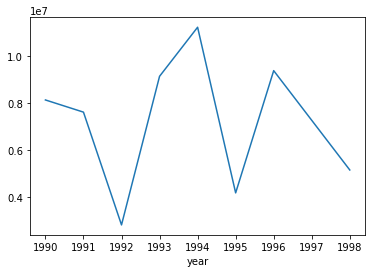

In [6]:
sub = df.loc[
    (df['country'] == 'South Africa') &
    (df['indicator'] == 'Production') &
    (df['admin_2'] == 'none') &
    (df['product'] == 'Maize')
]
sub
sub.groupby('year')['value'].sum().plot()

In [8]:
sub

,country,country_iso2,country_iso3,admin_1,admin_2,code,product,year,indicator,value,comments
533365,South Africa,ZA,ZAF,Mpumalanga,none,ZAF005,Maize,1992,Production,1091150.0,None
533366,South Africa,ZA,ZAF,Mpumalanga,none,ZAF005,Maize,1993,Production,2253475.0,None
533367,South Africa,ZA,ZAF,Mpumalanga,none,ZAF005,Maize,1994,Production,2670396.0,None
533369,South Africa,ZA,ZAF,North West,none,ZAF006,Maize,1994,Production,3634757.0,None
533370,South Africa,ZA,ZAF,North West,none,ZAF006,Maize,1993,Production,2465964.0,None
...,...,...,...,...,...,...,...,...,...,...,...
533534,South Africa,ZA,ZAF,Free State,none,ZAF002,Maize,1991,Production,2121035.0,None
533541,South Africa,ZA,ZAF,Guateng,none,ZAF003,Maize,1991,Production,435007.0,None
533542,South Africa,ZA,ZAF,Guateng,none,ZAF003,Maize,1992,Production,162386.0,None
533543,South Africa,ZA,ZAF,Guateng,none,ZAF003,Maize,1993,Production,716455.0,None


### FAO-STAT

In [77]:
# df[flag]

In [78]:
fn = './data/fao_stat/Production_Crops_Livestock_E_All_Data.csv'
df = pd.read_csv(fn,encoding='latin-1')
year = [col for col in df.columns if col[1:5].isdigit() & (len(col) == 5)]
year_int = [int(y[1:]) for y in year]
dict_year_int = {k:v for k, v in zip(year, year_int)}
flag = [col for col in df.columns if col[1:5].isdigit() & (len(col) == 6)]

data = df[['Area','Item','Element','Unit', *year]]
data = data.rename(columns={'Area':'country','Item':'product','Element':'indicator','Unit':'unit',**dict_year_int})
data

,country,product,indicator,unit,1961,1962,1963,1964,1965,1966,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,"Almonds, in shell",Area harvested,ha,NaN,NaN,NaN,NaN,NaN,NaN,...,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0,20053.0,29203.0,22134.0
1,Afghanistan,"Almonds, in shell",Yield,hg/ha,NaN,NaN,NaN,NaN,NaN,NaN,...,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0,17161.0,13083.0,17759.0
2,Afghanistan,"Almonds, in shell",Production,tonnes,NaN,NaN,NaN,NaN,NaN,NaN,...,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0,38205.0,39307.0
3,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",Area harvested,ha,NaN,NaN,NaN,NaN,NaN,NaN,...,19500.0,18500.0,18500.0,30000.0,25000.0,24500.0,26500.0,25333.0,25444.0,25759.0
4,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",Yield,hg/ha,NaN,NaN,NaN,NaN,NaN,NaN,...,6414.0,6757.0,6757.0,7167.0,7200.0,7075.0,7149.0,7142.0,7123.0,7138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77518,Net Food Importing Developing Countries,"Treenuts, Total",Yield,hg/ha,6118.0,6318.0,6618.0,6492.0,6417.0,6187.0,...,5401.0,5385.0,5169.0,5196.0,5262.0,5575.0,5835.0,5350.0,5476.0,5658.0
77519,Net Food Importing Developing Countries,"Treenuts, Total",Production,tonnes,255724.0,295318.0,315667.0,349663.0,341957.0,336409.0,...,1613861.0,1655268.0,1765728.0,1854309.0,2140896.0,1976746.0,2459880.0,2684323.0,2503026.0,2833231.0
77520,Net Food Importing Developing Countries,Vegetables Primary,Area harvested,ha,1877800.0,1925219.0,1992435.0,2054949.0,2039738.0,2138112.0,...,6410652.0,6439277.0,6561347.0,6800735.0,7114087.0,7072849.0,7086794.0,7289541.0,7399833.0,7649331.0
77521,Net Food Importing Developing Countries,Vegetables Primary,Yield,hg/ha,66297.0,67612.0,68080.0,69544.0,71377.0,72030.0,...,114103.0,115650.0,114295.0,116107.0,115705.0,116517.0,116936.0,116600.0,118337.0,118457.0


<AxesSubplot:>

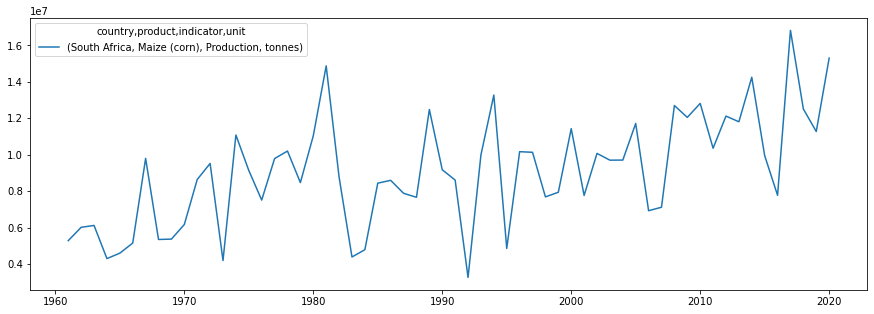

In [74]:
sub = df[
    (df['country'] == 'South Africa') &
    (df['product'] == 'Maize (corn)')
]
sub = sub.set_index(['country','product','indicator','unit']).T
sub.loc[:,pd.IndexSlice['South Africa','Maize (corn)','Production',:]].plot(figsize=[15,5])

In [43]:
sub = df[
    
years]

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2016,Y2016F,Y2017,Y2017F,Y2018,Y2018F,Y2019,Y2019F,Y2020,Y2020F
0,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5312,Area harvested,ha,NaN,...,19481.0,A,19793.0,A,20053.0,A,29203.0,A,22134.0,A
1,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5419,Yield,hg/ha,NaN,...,16859.0,E,13788.0,E,17161.0,E,13083.0,E,17759.0,E
2,2,'004,Afghanistan,221,'01371,"Almonds, in shell",5510,Production,tonnes,NaN,...,32843.0,A,27291.0,A,34413.0,A,38205.0,A,39307.0,A
3,2,'004,Afghanistan,711,'01654,"Anise, badian, coriander, cumin, caraway, fenn...",5312,Area harvested,ha,NaN,...,24500.0,E,26500.0,E,25333.0,E,25444.0,E,25759.0,E
4,2,'004,Afghanistan,711,'01654,"Anise, badian, coriander, cumin, caraway, fenn...",5419,Yield,hg/ha,NaN,...,7075.0,E,7149.0,E,7142.0,E,7123.0,E,7138.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77518,5817,'902,Net Food Importing Developing Countries,1729,'F1729,"Treenuts, Total",5419,Yield,hg/ha,6118.0,...,5575.0,E,5835.0,E,5350.0,E,5476.0,E,5658.0,E
77519,5817,'902,Net Food Importing Developing Countries,1729,'F1729,"Treenuts, Total",5510,Production,tonnes,255724.0,...,1976746.0,E,2459880.0,E,2684323.0,E,2503026.0,E,2833231.0,E
77520,5817,'902,Net Food Importing Developing Countries,1735,'F1735,Vegetables Primary,5312,Area harvested,ha,1877800.0,...,7072849.0,E,7086794.0,E,7289541.0,E,7399833.0,E,7649331.0,E
77521,5817,'902,Net Food Importing Developing Countries,1735,'F1735,Vegetables Primary,5419,Yield,hg/ha,66297.0,...,116517.0,E,116936.0,E,116600.0,E,118337.0,E,118457.0,E


In [25]:
# df[['Item Code','Item Code (CPC)','Item']].drop_duplicates()
# temp = df[['Item Code','Item Code (CPC)','Item','Element Code','Element','Unit']].drop_duplicates()
# temp.to_csv('./removable.csv')

60

In [32]:
a = 'Y2017F'
a[1:5


True

In [23]:
sub = df[
    (df['Area'] == 'South Africa') &
    (df['Item'] == 'Maize (corn)')
]

In [24]:
sub

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2016,Y2016F,Y2017,Y2017F,Y2018,Y2018F,Y2019,Y2019F,Y2020,Y2020F
48845,202,'710,South Africa,56,'0112,Maize (corn),5312,Area harvested,ha,4118000.0,...,1946750.0,A,2628600.0,A,2318850.0,A,2300500.0,A,2610800.0,A
48846,202,'710,South Africa,56,'0112,Maize (corn),5419,Yield,hg/ha,12853.0,...,39956.0,E,63988.0,E,53949.0,E,49013.0,E,58603.0,E
48847,202,'710,South Africa,56,'0112,Maize (corn),5510,Production,tonnes,5293000.0,...,7778500.0,A,16820000.0,A,12510000.0,A,11275500.0,A,15300000.0,A


In [14]:
7778500.0/1946750.0*10000

39956.337485552845

In [2]:
# fn = './removable/KEN/AgroMaps/Africa/admin2_data/KEN.DBF'
fn = './removable/BFA/AgroMaps/Africa/admin1_data/BFA.DBF'
df = gpd.read_file(fn)
df

DriverError: ./removable/BFA/AgroMaps/Africa/admin1_data/BFA.DBF: No such file or directory

In [17]:
sorted(df['YEAR'].unique())

[1984.0,
 1985.0,
 1986.0,
 1987.0,
 1988.0,
 1989.0,
 1990.0,
 1991.0,
 1992.0,
 1993.0,
 1994.0,
 1995.0,
 1997.0,
 2000.0,
 2001.0]